In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"osandasamaratunge","key":"eb1110a0775a21946eeea8ba0c17c672"}'}

In [4]:
!kaggle datasets download -d joebeachcapital/realwaste --unzip

Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/realwaste
License(s): Attribution 4.0 International (CC BY 4.0)
 97% 640M/657M [00:08<00:00, 132MB/s]
100% 657M/657M [00:08<00:00, 79.7MB/s]


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Waste Material Classification using CNN

This notebook implements a Convolutional Neural Network to classify waste materials into 9 categories: Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, and Vegetation.


### Import Libraries

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## Dataset Configuration
- Resize the 524x524 to 224x224
- Set the batch size to 32. The number of data samples (images) that will be processed simultaneously during one forward/backward pass of the model
- Number of distinct classes for which the classification should be done is set to 9.
- Total number of epoch count is set to 20.

In [6]:
# Dataset parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 9
NUM_EPOCHS = 20

# Class names and their counts
CLASS_NAMES = [
    'Cardboard',         # 461
    'Food_Organics',     # 411
    'Glass',             # 420
    'Metal',             # 790
    'Miscellaneous',     # 495
    'Paper',             # 500
    'Plastic',           # 921
    'Textile',           # 318
    'Vegetation'         # 436
]

# Correct the data directory path based on the unzipped location
DATA_DIR = '/content/realwaste-main/RealWaste'

## Dataset class

In [7]:
class WasteDataset(Dataset):
    """Custom Dataset for loading waste material images"""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the class folders
            transform (callable, optional): Optional transform to be applied on images
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []

        # Load all images and labels
        # In WasteDataset.__init__, replace the file collection loop with this:
        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                # Get all image files and SORT them for consistency
                image_files = sorted([f for f in class_dir.glob('*.*')
                                    if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])

                for img_path in image_files:
                    self.images.append(str(img_path))
                    self.labels.append(class_idx)

        print(f"Loaded {len(self.images)} images from {len(CLASS_NAMES)} classes")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## Calculating normalization values
- Calculate μ and σ for each channel (R, G, B) of the specific training set using 1000 images from that dataset.

In [8]:
def calculate_mean_std(dataset_path, image_size=224, sample_size=None):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    temp_dataset = WasteDataset(root_dir=dataset_path, transform=transform)

    if sample_size and sample_size < len(temp_dataset):
        indices = np.random.choice(len(temp_dataset), sample_size, replace=False)
        temp_dataset = torch.utils.data.Subset(temp_dataset, indices)

    loader = DataLoader(temp_dataset, batch_size=32, shuffle=False, num_workers=2)

    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_pixels = 0

    for images, _ in loader:
        channels_sum += torch.mean(images, dim=[0, 2, 3]) * images.size(0)
        channels_squared_sum += torch.mean(images ** 2, dim=[0, 2, 3]) * images.size(0)
        num_pixels += images.size(0)

    mean = channels_sum / num_pixels
    std = torch.sqrt(channels_squared_sum / num_pixels - mean ** 2)

    print(f"Dataset Mean (R, G, B): [{mean[0]:.4f}, {mean[1]:.4f}, {mean[2]:.4f}]")
    print(f"Dataset Std (R, G, B): [{std[0]:.4f}, {std[1]:.4f}, {std[2]:.4f}]")

    return mean.tolist(), std.tolist()

# Recalculate mean and std with the correct DATA_DIR
dataset_mean, dataset_std = calculate_mean_std(DATA_DIR, IMAGE_SIZE, sample_size=1000)

Loaded 3528 images from 9 classes
Dataset Mean (R, G, B): [0.5900, 0.6152, 0.6330]
Dataset Std (R, G, B): [0.1575, 0.1575, 0.1844]


## Data augmentation and pre-processing
### Training dataset
- Resizing
- Random horizontal flip
- Random rotation
- Color jitter (Randomly alter the brightness, contrast, and saturation)
- Convert the image from a PIL Image to a PyTorch Tensor and automatically scale pixel values from [0,255] to the floating-point range of [0.0,1.0]
- Standardize the Tensor data

### Validation data set
- Resizing
- Tensor conversion
- Normalization


In [10]:
# Training transforms with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

# Validation and test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

## Load and split data set
- Load the full data set and split it into 70% training, 15% validation and 15% testing.
- Create the necessary data loaders

### A new data-split mechanism to create three datasets with the split images.

In [11]:
class ImageListDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load full dataset once to get all paths and labels
temp_dataset = WasteDataset(root_dir=DATA_DIR, transform=None)

# Get all images and labels
all_images = temp_dataset.images
all_labels = temp_dataset.labels

print(f"Total images: {len(all_images)}")

# STRATIFIED SPLIT - Ensure each class is represented in all splits
from sklearn.model_selection import train_test_split

# First split: separate train from (val + test)
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels,
    test_size=0.3,  # 30% for val + test
    stratify=all_labels,  # This ensures class distribution is maintained
    random_state=42
)

# Second split: separate val from test
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels,
    test_size=0.5,  # Split 50/50 between val and test (15% each)
    stratify=temp_labels,  # Maintain class distribution
    random_state=42
)

# Create datasets with appropriate transforms
train_dataset = ImageListDataset(
    train_images, train_labels, transform=train_transform
)

val_dataset = ImageListDataset(
    val_images, val_labels, transform=val_test_transform
)

test_dataset = ImageListDataset(
    test_images, test_labels, transform=val_test_transform
)

print(f"\nDataset Split (Stratified):")
print(f"Training: {len(train_dataset)} images ({len(train_dataset)/len(all_images)*100:.1f}%)")
print(f"Validation: {len(val_dataset)} images ({len(val_dataset)/len(all_images)*100:.1f}%)")
print(f"Testing: {len(test_dataset)} images ({len(test_dataset)/len(all_images)*100:.1f}%)")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                       shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=2, pin_memory=True)

# VERIFICATION: Check class distribution in each split
print(f"\n" + "="*60)
print("CLASS DISTRIBUTION VERIFICATION")
print("="*60)

def check_class_distribution(labels, dataset_name):
    print(f"\n{dataset_name} Class Distribution:")
    class_counts = {class_name: 0 for class_name in CLASS_NAMES}

    for label in labels:
        class_name = CLASS_NAMES[label]
        class_counts[class_name] += 1

    # Print counts for each class
    for class_name in CLASS_NAMES:
        count = class_counts[class_name]
        percentage = (count / len(labels)) * 100
        print(f"  {class_name:<15}: {count:>3} images ({percentage:5.1f}%)")

    # Check if all classes are represented
    missing_classes = [class_name for class_name, count in class_counts.items() if count == 0]
    if missing_classes:
        print(f"  ⚠️  MISSING CLASSES: {missing_classes}")
    else:
        print(f"  ✅ All 9 classes represented")

    return class_counts

# Check distribution for all datasets
train_counts = check_class_distribution(train_labels, "TRAINING")
val_counts = check_class_distribution(val_labels, "VALIDATION")
test_counts = check_class_distribution(test_labels, "TEST")

# Final verification
print(f"\n" + "="*50)
print("FINAL VERIFICATION")
print("="*50)
all_good = True
for class_name in CLASS_NAMES:
    train_has = train_counts[class_name] > 0
    val_has = val_counts[class_name] > 0
    test_has = test_counts[class_name] > 0

    status = "✅" if (train_has and val_has and test_has) else "❌"
    print(f"  {class_name:<15}: {status} Train:{train_has} Val:{val_has} Test:{test_has}")

    if not (train_has and val_has and test_has):
        all_good = False

if all_good:
    print(f"\n🎉 SUCCESS: All 9 classes are represented in ALL splits!")
else:
    print(f"\n❌ PROBLEM: Some classes are missing from splits!")

Loaded 3528 images from 9 classes
Total images: 3528

Dataset Split (Stratified):
Training: 2469 images (70.0%)
Validation: 529 images (15.0%)
Testing: 530 images (15.0%)

CLASS DISTRIBUTION VERIFICATION

TRAINING Class Distribution:
  Cardboard      : 323 images ( 13.1%)
  Food_Organics  :   0 images (  0.0%)
  Glass          : 294 images ( 11.9%)
  Metal          : 553 images ( 22.4%)
  Miscellaneous  :   0 images (  0.0%)
  Paper          : 350 images ( 14.2%)
  Plastic        : 644 images ( 26.1%)
  Textile        :   0 images (  0.0%)
  Vegetation     : 305 images ( 12.4%)
  ⚠️  MISSING CLASSES: ['Food_Organics', 'Miscellaneous', 'Textile']

VALIDATION Class Distribution:
  Cardboard      :  69 images ( 13.0%)
  Food_Organics  :   0 images (  0.0%)
  Glass          :  63 images ( 11.9%)
  Metal          : 118 images ( 22.3%)
  Miscellaneous  :   0 images (  0.0%)
  Paper          :  75 images ( 14.2%)
  Plastic        : 138 images ( 26.1%)
  Textile        :   0 images (  0.0%)
  


TRAINING DATASET SAMPLES - DETAILED VIEW

Sample 1: Plastic (Label 6)
File: Plastic_527.jpg


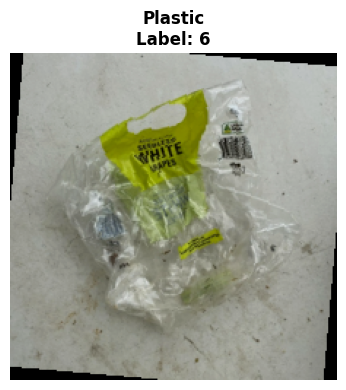


Sample 2: Glass (Label 2)
File: Glass_203.jpg


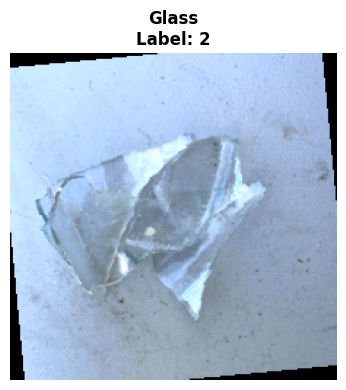


Sample 3: Metal (Label 3)
File: Metal_340.jpg


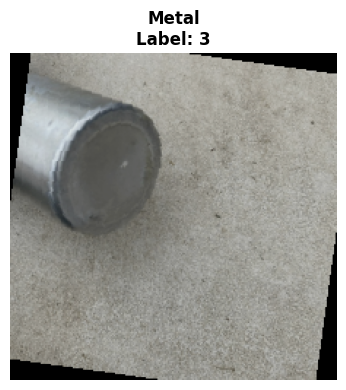


Sample 4: Paper (Label 5)
File: Paper_478.jpg


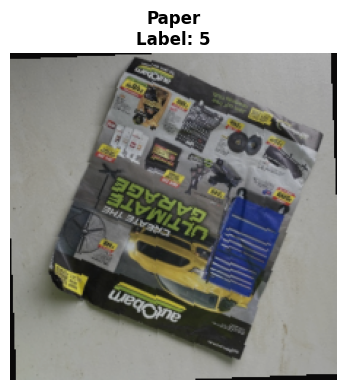


Sample 5: Plastic (Label 6)
File: Plastic_525.jpg


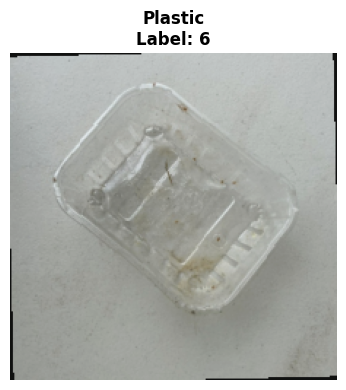


Sample 6: Vegetation (Label 8)
File: Vegetation_412.jpg


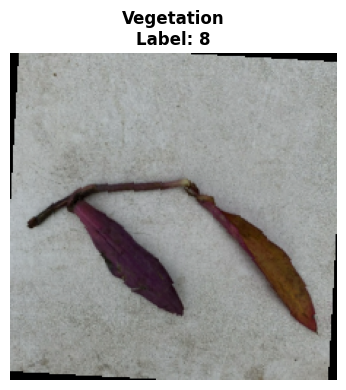


Sample 7: Metal (Label 3)
File: Metal_355.jpg


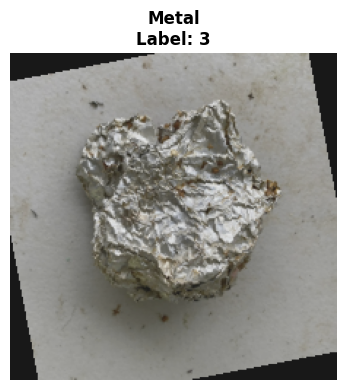


Sample 8: Metal (Label 3)
File: Metal_323.jpg


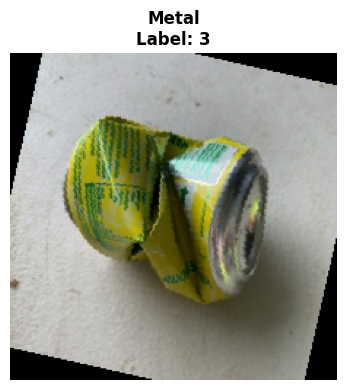


Sample 9: Glass (Label 2)
File: Glass_286.jpg


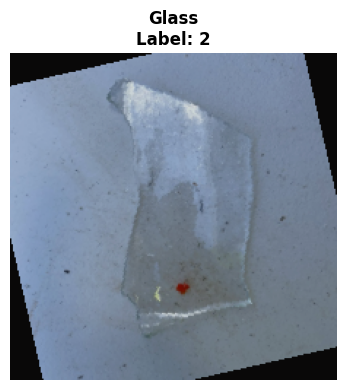


Sample 10: Plastic (Label 6)
File: Plastic_418.jpg


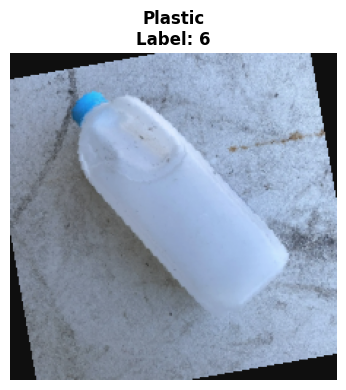


Sample 11: Metal (Label 3)
File: Metal_423.jpg


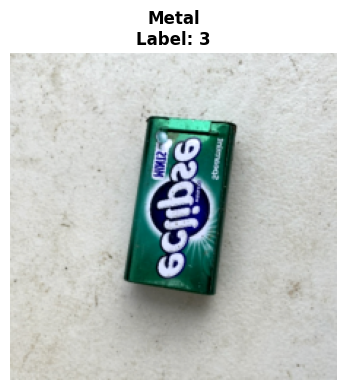


Sample 12: Glass (Label 2)
File: Glass_161.jpg


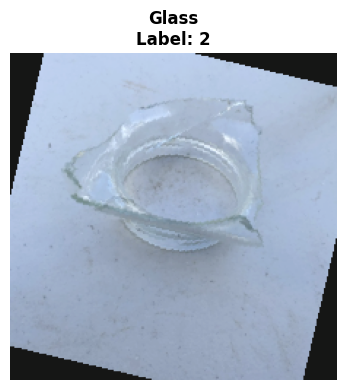


Sample 13: Plastic (Label 6)
File: Plastic_454.jpg


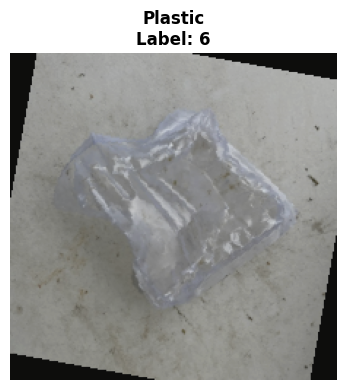


Sample 14: Vegetation (Label 8)
File: Vegetation_252.jpg


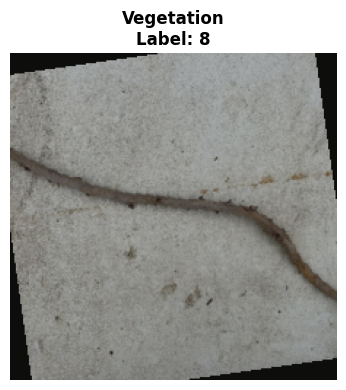


Sample 15: Plastic (Label 6)
File: Plastic_556.jpg


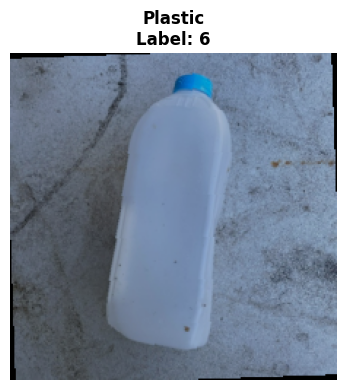


Sample 16: Plastic (Label 6)
File: Plastic_673.jpg


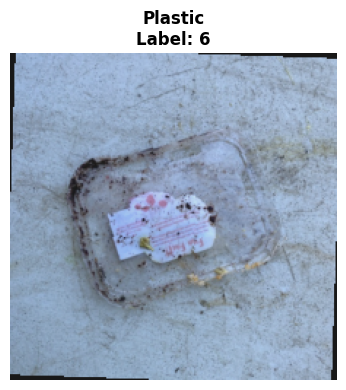


Sample 17: Glass (Label 2)
File: Glass_376.jpg


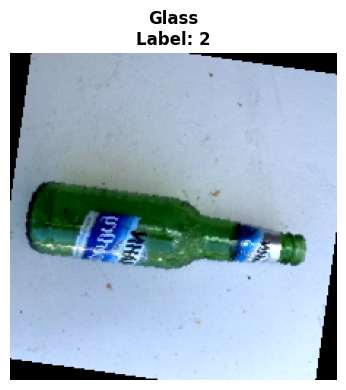


Sample 18: Metal (Label 3)
File: Metal_779.jpg


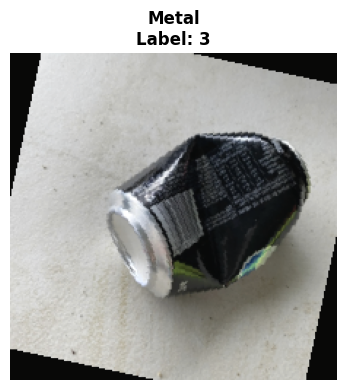


Sample 19: Plastic (Label 6)
File: Plastic_755.jpg


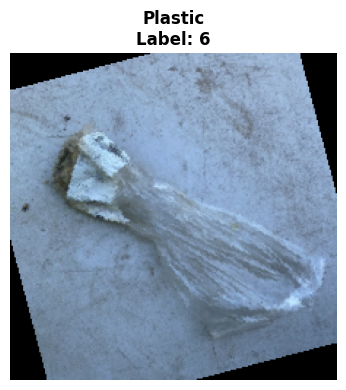


Sample 20: Vegetation (Label 8)
File: Vegetation_245.jpg


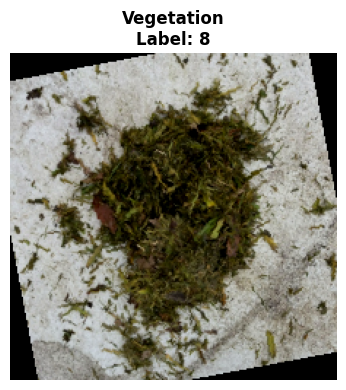

In [22]:
# Simple version - show images one by one with details
print(f"\n" + "="*60)
print("TRAINING DATASET SAMPLES - DETAILED VIEW")
print("="*60)

# Select 20 random indices
import random
sample_indices = random.sample(range(len(train_dataset)), min(20, len(train_dataset)))

for i, idx in enumerate(sample_indices):
    # Get the image and label
    image_tensor, label = train_dataset[idx]
    class_name = CLASS_NAMES[label]
    img_path = train_dataset.image_paths[idx]

    # Denormalize for display
    image = image_tensor.numpy().transpose((1, 2, 0))
    mean = np.array(dataset_mean)
    std = np.array(dataset_std)
    image = image * std + mean
    image = np.clip(image, 0, 1)

    print(f"\nSample {i+1}: {class_name} (Label {label})")
    print(f"File: {Path(img_path).name}")

    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f'{class_name}\nLabel: {label}', fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# full_dataset = WasteDataset(root_dir=DATA_DIR, transform=train_transform)

# total_size = len(full_dataset)
# train_size = int(0.70 * total_size)
# val_size = int(0.15 * total_size)
# test_size = total_size - train_size - val_size

# print(f"\nDataset Split:")
# print(f"Training: {train_size} images ({train_size/total_size*100:.1f}%)")
# print(f"Validation: {val_size} images ({val_size/total_size*100:.1f}%)")
# print(f"Testing: {test_size} images ({test_size/total_size*100:.1f}%)")

# # Split dataset
# train_dataset, val_dataset, test_dataset = random_split(
#     full_dataset, [train_size, val_size, test_size],
#     generator=torch.Generator().manual_seed(42)
# )

# # Apply appropriate transforms
# val_dataset.dataset.transform = val_test_transform
# test_dataset.dataset.transform = val_test_transform

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
#                          shuffle=True, num_workers=4, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
#                        shuffle=False, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
#                         shuffle=False, num_workers=4, pin_memory=True)

## CNN model architecture
### Feature Extraction

- Convo1ution layer 1: 32 filters, 5x5 kernel, ReLU activation
- MaxPool: 2x2
- Convo1ution layer 2: 64 filters, 3x3 kernel, ReLU activation
- MaxPool: 2x2
- Convo1ution layer 3: 128 filters, 3x3 kernel, ReLU activation (added for better feature extraction)
- MaxPool: 2x2

### Classification
- Flatten
- Fully Connected layer 1: 512 units, ReLU activation
    - with Dropout: 0.5
- Fully Connected layer 2: 256 units, ReLU activation
    - With Dropout: 0.3
- Output: 9 units, Softmax

In [12]:
class WasteCNN(nn.Module):

    def __init__(self, num_classes=9):
        super(WasteCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First convolutional block
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second convolutional block
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third convolutional block
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Input: 224x224 -> after 3 maxpools (2x2): 224/8 = 28x28
        self.flatten_size = 128 * 28 * 28

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize model weights using He initialization"""

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Create model and move to GPU
model = WasteCNN(num_classes=NUM_CLASSES).to(device)

print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print(model)
print("\nTotal parameters:", sum(p.numel() for p in model.parameters()))
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


MODEL ARCHITECTURE
WasteCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, o

## Loss function and Optimizer
- Loss function -> Cross entropy loss
- Optimizer -> Adaptive Moment Estimation (ADAM)
- Learning rate scheduler -> Reduce LR On Plateau

In [13]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

## Training and Validation

In [14]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

## Training Loop

In [15]:
# Lists to store history
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
best_model_state = None

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Store history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()

    epoch_time = time.time() - epoch_start_time

    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ({epoch_time:.2f}s) - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.2f} minutes")

model.load_state_dict(best_model_state)

Epoch [1/20] (24.52s) - Train Loss: 1.8176, Train Acc: 30.66% | Val Loss: 1.4687, Val Acc: 37.81%
Epoch [2/20] (22.11s) - Train Loss: 1.4309, Train Acc: 42.00% | Val Loss: 1.2330, Val Acc: 45.37%
Epoch [3/20] (22.94s) - Train Loss: 1.3413, Train Acc: 47.02% | Val Loss: 1.1720, Val Acc: 57.28%
Epoch [4/20] (26.19s) - Train Loss: 1.2862, Train Acc: 47.35% | Val Loss: 1.1348, Val Acc: 58.79%
Epoch [5/20] (22.78s) - Train Loss: 1.2510, Train Acc: 50.18% | Val Loss: 1.0277, Val Acc: 62.00%
Epoch [6/20] (24.09s) - Train Loss: 1.1672, Train Acc: 55.29% | Val Loss: 0.9453, Val Acc: 66.73%
Epoch [7/20] (22.62s) - Train Loss: 1.1225, Train Acc: 55.61% | Val Loss: 1.0079, Val Acc: 63.14%
Epoch [8/20] (21.85s) - Train Loss: 1.1304, Train Acc: 55.08% | Val Loss: 0.9241, Val Acc: 63.33%
Epoch [9/20] (22.92s) - Train Loss: 1.1062, Train Acc: 57.59% | Val Loss: 0.8791, Val Acc: 67.67%
Epoch [10/20] (22.84s) - Train Loss: 1.0497, Train Acc: 59.90% | Val Loss: 0.9136, Val Acc: 68.43%
Epoch [11/20] (22.8

<All keys matched successfully>

## Training history graphs

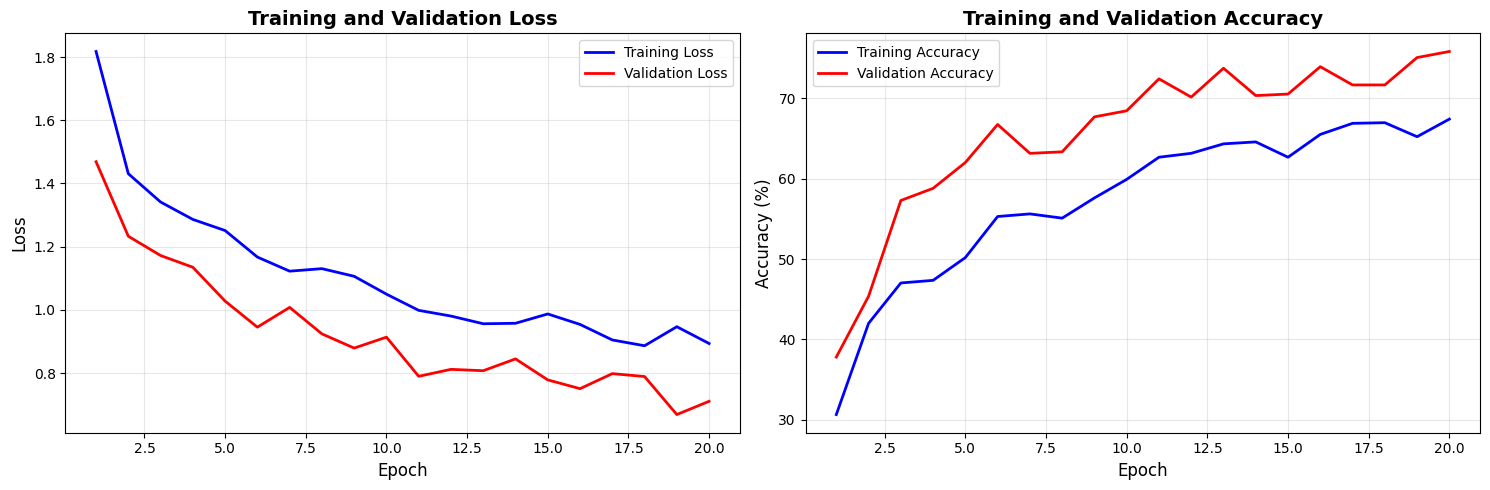


Best validation loss: 0.6687


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(range(1, NUM_EPOCHS+1), train_losses, 'b-', label='Training Loss', linewidth=2)
axes[0].plot(range(1, NUM_EPOCHS+1), val_losses, 'r-', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(range(1, NUM_EPOCHS+1), train_accs, 'b-', label='Training Accuracy', linewidth=2)
axes[1].plot(range(1, NUM_EPOCHS+1), val_accs, 'r-', label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest validation loss: {best_val_loss:.4f}")

## Evaluation on test set


Test Accuracy: 71.13%

SAMPLE TEST IMAGES WITH PREDICTIONS

Sample 1: ❌ WRONG
  True Label:  Glass (Class 2)
  Predicted:   Metal (Class 3)


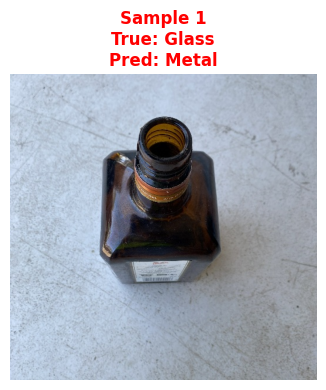


Sample 2: ✅ CORRECT
  True Label:  Vegetation (Class 8)
  Predicted:   Vegetation (Class 8)


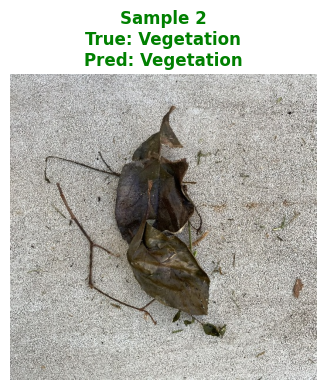


Sample 3: ✅ CORRECT
  True Label:  Paper (Class 5)
  Predicted:   Paper (Class 5)


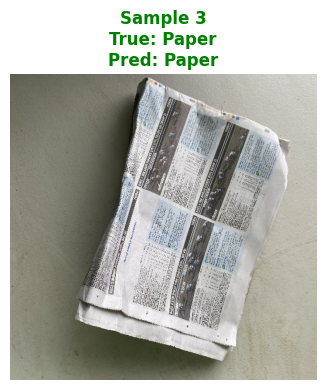


Sample 4: ✅ CORRECT
  True Label:  Vegetation (Class 8)
  Predicted:   Vegetation (Class 8)


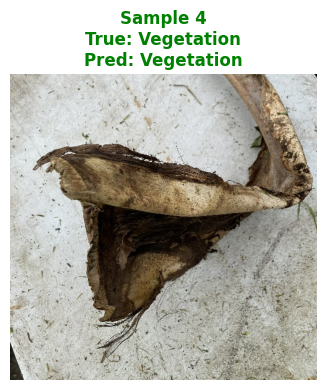


Sample 5: ✅ CORRECT
  True Label:  Paper (Class 5)
  Predicted:   Paper (Class 5)


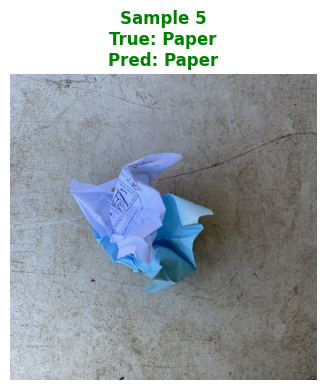


Sample 6: ❌ WRONG
  True Label:  Metal (Class 3)
  Predicted:   Plastic (Class 6)


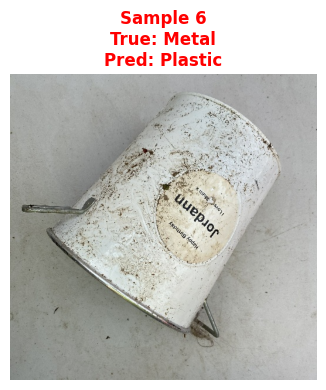


Sample 7: ❌ WRONG
  True Label:  Metal (Class 3)
  Predicted:   Plastic (Class 6)


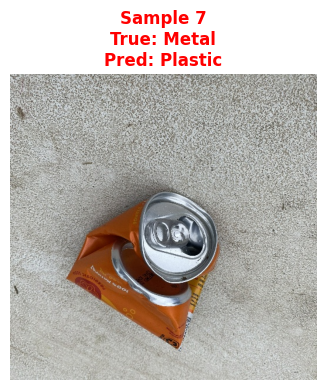


Sample 8: ✅ CORRECT
  True Label:  Cardboard (Class 0)
  Predicted:   Cardboard (Class 0)


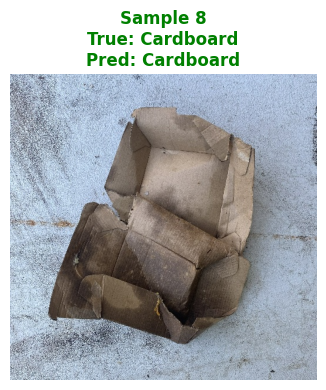

ZeroDivisionError: division by zero

In [21]:
# Simple approach - directly sample from test dataset
model.eval()
all_preds = []
all_labels = []

print(f"\nTest Accuracy: {test_accuracy:.2f}%")
print(f"\n" + "="*60)
print("SAMPLE TEST IMAGES WITH PREDICTIONS")
print("="*60)

# Show first 8 images from test dataset directly
for i in range(min(8, len(test_dataset))):
    # Get the original image and label
    image_tensor, true_label = test_dataset[i]
    true_class = CLASS_NAMES[true_label]

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0).to(device))
        _, predicted = torch.max(output.data, 1)
        pred_label = predicted.cpu().item()
        pred_class = CLASS_NAMES[pred_label]

    # Check if prediction is correct
    is_correct = true_label == pred_label
    status = "✅ CORRECT" if is_correct else "❌ WRONG"

    print(f"\nSample {i+1}: {status}")
    print(f"  True Label:  {true_class} (Class {true_label})")
    print(f"  Predicted:   {pred_class} (Class {pred_label})")

    # Display original image (get it from the image_paths)
    if hasattr(test_dataset, 'image_paths'):
        original_image = Image.open(test_dataset.image_paths[i]).convert('RGB')
        plt.figure(figsize=(4, 4))
        plt.imshow(original_image)
        plt.title(f"Sample {i+1}\nTrue: {true_class}\nPred: {pred_class}",
                  color='green' if is_correct else 'red',
                  fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Calculate final accuracy
correct_total = sum(1 for i in range(len(all_preds)) if all_preds[i] == all_labels[i])
print(f"\nFinal Test Accuracy: {100 * correct_total / len(all_preds):.2f}%")